<a href="https://colab.research.google.com/github/tianyuanshao/MarchMadnessClassifier/blob/main/CBProject(11/22).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Import drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [32]:
# Import libraries 
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn as sk
import sklearn.metrics as skm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [33]:
# Import datasets 

# ALL YEARS
cbb = pd.read_csv('/content/drive/MyDrive/CS271P/FinalProject/Datafiles/cbb.csv') 

In [34]:
# EDA: Basics
cbb.head(5)     # Obtain first 5 rows
len(cbb['CONF'].unique())   # Obtain distinct number of CONF variables (Athletic conference of school participation)
len(cbb.columns)    # Obtain total number of variables 
len(cbb.index)      # Obtain total number of rows
cbb.dtypes          # Types per columns
cbb.shape           # Dimensions of data frame

(2455, 24)

In [35]:
# Check for duplicate rows -CG
cbb_duplicated = cbb[cbb.duplicated()]
cbb_duplicated

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR


In [36]:
# EDA: Transforming Null Values/New Variable Assignments
cbb.isnull().sum()    # Obtain number of null values for each variable

# 1 = TRUE, 0 = FALSE
cbb['MAKE'] = np.where(pd.isnull(cbb.SEED), 0, 1)   # Create new bool variable MAKE for team making it into tournament 
cbb['CHAMP'] = np.where(cbb['POSTSEASON'] == 'Champions', 1, 0)   # Create new bool variable CHAMP for team winning Championship
cbb['FINALS'] = np.where(np.logical_or(cbb['POSTSEASON'] == 'Champions', cbb['POSTSEASON'] == '2ND')  , 1, 0)   # Create new bool variable FINAlS for teams making it to the finals
len(cbb.columns)

27

In [37]:
# EDA: Transforming Wins Over Games Variables to Win Percentages
cbb.insert(2, 'WP', cbb.apply(lambda x:x['W']/x['G'], axis = 1))
cbb

,TEAM,CONF,WP,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,MAKE,CHAMP,FINALS
0,North Carolina,ACC,0.825000,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016,1,0,1
1,Wisconsin,B10,0.900000,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015,1,0,1
2,Michigan,B10,0.825000,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018,1,0,1
3,Texas Tech,B12,0.815789,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019,1,0,1
4,Gonzaga,WCC,0.948718,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2450,Michigan St.,B10,0.742857,35,26,111.4,87.8,0.9392,50.6,44.5,20.8,19.2,36.1,27.6,36.6,32.4,50.4,44.3,34.1,30.1,64.4,6.7,S16,3.0,2013,1,0,0
2451,Arizona,P12,0.771429,35,27,114.4,92.2,0.9229,52.5,46.6,19.5,19.8,35.0,26.7,37.4,32.9,50.6,43.4,37.1,35.8,66.8,4.6,S16,6.0,2013,1,0,0
2452,Oregon,P12,0.756757,37,28,104.8,88.6,0.8728,49.3,46.4,21.4,22.0,35.8,27.2,38.4,33.3,49.1,44.9,33.3,33.4,69.2,2.9,S16,12.0,2013,1,0,0
2453,La Salle,A10,0.705882,34,24,112.0,96.2,0.8516,51.9,49.3,17.1,21.3,29.0,34.2,31.3,28.5,49.3,50.6,37.7,30.2,66.0,0.3,S16,13.0,2013,1,0,0


In [38]:
# EDA: Numerical Variables
cbbnum = cbb.drop(columns = ['YEAR', 'CONF', 'POSTSEASON', 'SEED', 'MAKE', 'CHAMP', 'FINALS'])  # Include only columns with numerical values
cbbnum.describe()       # Summary statistics for numerical variables 
#cbbnum.WP.hist()
#cbbnum.G.hist()
#cbbnum.W.hist()
#cbbnum.ADJOE.hist()
#cbbnum.ADJDE.hist()
#cbbnum.BARTHAG.hist()
#cbbnum.EFG_O.hist()
#cbbnum.EFG_D.hist()
#cbbnum.TOR.hist()
#cbbnum.TORD.hist()
#cbbnum.ORB.hist()
#cbbnum.DRB.hist()
#cbbnum.FTR.hist()
#cbbnum.FTRD.hist()
#cbbnum.2P_O.hist()
#cbbnum.2P_D.hist()
#cbbnum.3P_O.hist()
#cbbnum.3P_D.hist()
#cbbnum.ADJ_T.hist()
#cbbnum.WAB.hist()

,WP,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB
count,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.00000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000
mean,0.508203,31.492464,16.284318,103.304481,103.304603,0.493957,49.805132,50.001385,18.763055,18.689572,29.875642,30.075479,35.989776,36.26998,48.802281,48.976660,34.406395,34.598737,67.812301,-7.802485
std,0.179726,2.657401,6.610960,7.376981,6.605318,0.256244,3.143061,2.939602,2.090595,2.201749,4.134332,3.151454,5.247820,6.24590,3.384468,3.340546,2.789434,2.415766,3.277622,6.965736
min,0.000000,15.000000,0.000000,76.600000,84.000000,0.005000,39.200000,39.600000,11.900000,10.200000,15.000000,18.400000,21.600000,21.80000,37.700000,37.700000,24.900000,27.100000,57.200000,-25.200000
25%,0.379310,30.000000,11.000000,98.300000,98.500000,0.282200,47.750000,48.000000,17.300000,17.200000,27.100000,27.900000,32.400000,31.90000,46.500000,46.700000,32.500000,33.000000,65.700000,-13.000000
50%,0.516129,31.000000,16.000000,103.000000,103.500000,0.475000,49.700000,50.000000,18.700000,18.600000,29.900000,30.000000,35.800000,35.80000,48.700000,49.000000,34.400000,34.600000,67.800000,-8.300000
75%,0.636364,33.000000,21.000000,108.000000,107.900000,0.712200,51.900000,52.000000,20.100000,20.100000,32.600000,32.200000,39.500000,40.20000,51.000000,51.300000,36.300000,36.200000,70.000000,-3.150000
max,0.974359,40.000000,38.000000,129.100000,124.000000,0.984200,59.800000,59.500000,27.100000,28.500000,43.600000,40.400000,58.600000,60.70000,62.600000,61.200000,44.100000,43.100000,83.400000,13.100000


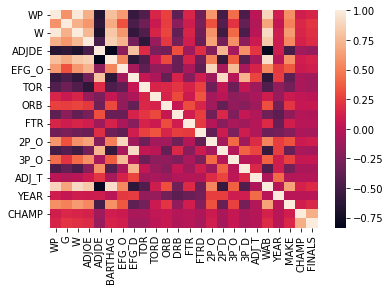

In [39]:
# EDA: Heatmap
cbbnew = cbb.drop(columns = ['SEED', 'POSTSEASON'])     # Drop columns with null values (already transformed)
len(cbbnew.columns)
cbbnew.isnull().sum()     # Check for null values

# Can customize correlation method (Pearson by default): https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html -CG
sb.heatmap(cbbnew.corr())    # Plot heatmap for database

In [40]:
# Detect Outliers by IQR
Q1 = cbbnew.quantile(.25)
Q3 = cbbnew.quantile(.75)
IQR = Q3 - Q1

outliers = cbbnew[((cbbnew < (Q1 - (IQR * 3))) |(cbbnew > (Q3 + (IQR * 3)))).any(axis=1)]
outliers.shape

(479, 26)

In [41]:
# Boxplots

# sb.boxplot(x = cbbnew['WP'], width = 0.5).set(xlabel = 'Win Percentages')
# sb.boxplot(x=cbbnew['ADJOE'])
# sb.boxplot(x=cbbnew['ADJDE'])
# sb.boxplot(x=cbbnew['BARTHAG'])
# sb.boxplot(x=cbbnew['EFG_O'])
# sb.boxplot(x=cbbnew['EFG_D'])
# sb.boxplot(x=cbbnew['TOR'])
# sb.boxplot(x=cbbnew['TORD'])
# sb.boxplot(x=cbbnew['ORB'])
# sb.boxplot(x=cbbnew['DRB'])
# sb.boxplot(x=cbbnew['FTR'])
# sb.boxplot(x=cbbnew['FTRD'])
# sb.boxplot(x=cbbnew['2P_O'])
# sb.boxplot(x=cbbnew['2P_D'])
# sb.boxplot(x=cbbnew['3P_O'])
# sb.boxplot(x=cbbnew['3P_D'])
# sb.boxplot(x=cbbnew['ADJ_T'])
# sb.boxplot(x=cbbnew['WAB']) 

In [30]:
# EDA: Mean Statistics for Teams
cbbnew.groupby('TEAM').mean()

,WP,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,YEAR,MAKE,CHAMP,FINALS
TEAM,,,,,,,,,,,,,,,,,,,,,,,,
Abilene Christian,0.445000,26.500000,12.333333,96.150000,109.050000,0.220150,49.966667,53.383333,19.983333,20.716667,25.133333,30.866667,35.183333,44.216667,47.466667,53.400000,36.333333,35.600000,66.883333,-11.950000,2016.5,0.166667,0.0,0.0
Air Force,0.422396,29.714286,12.571429,101.971429,106.057143,0.390086,50.642857,52.957143,19.000000,18.914286,25.871429,28.600000,33.714286,35.385714,50.042857,52.485714,34.400000,35.657143,66.071429,-10.200000,2016.0,0.000000,0.0,0.0
Akron,0.641979,33.000000,21.285714,104.671429,99.928571,0.627429,51.171429,47.928571,18.457143,18.500000,30.814286,30.128571,33.657143,35.300000,49.971429,47.185714,34.928571,33.128571,66.914286,-4.971429,2016.0,0.142857,0.0,0.0
Alabama,0.535767,33.714286,18.142857,106.585714,94.985714,0.789186,49.714286,47.071429,19.571429,19.200000,30.700000,31.357143,40.185714,36.942857,49.871429,46.271429,32.957143,32.414286,65.785714,-1.857143,2016.0,0.142857,0.0,0.0
Alabama A&M,0.243395,29.285714,7.000000,91.014286,113.071429,0.090200,45.214286,51.057143,20.942857,17.785714,30.500000,33.571429,36.342857,39.100000,45.528571,50.757143,29.728571,34.528571,65.985714,-18.428571,2016.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wright St.,0.594915,32.428571,19.428571,100.514286,98.914286,0.546800,50.500000,49.800000,18.914286,21.271429,25.871429,27.442857,35.557143,39.085714,48.928571,49.128571,35.471429,33.971429,66.400000,-7.242857,2016.0,0.142857,0.0,0.0
Wyoming,0.528222,32.142857,17.142857,102.600000,101.585714,0.535014,51.514286,48.628571,18.085714,17.771429,20.000000,28.942857,41.357143,34.785714,51.357143,47.442857,34.328571,33.885714,66.514286,-7.171429,2016.0,0.142857,0.0,0.0
Xavier,0.659170,34.857143,23.000000,113.814286,96.842857,0.852571,52.442857,49.442857,18.542857,17.571429,33.114286,26.685714,39.700000,31.942857,52.400000,48.814286,35.142857,33.628571,67.671429,1.985714,2016.0,0.714286,0.0,0.0


In [48]:
# EDA: Creating Training Data
y = cbb['MAKE']         # Set target value to FINALS
cbb['MAKE'].value_counts()
cbb
x = cbb.drop(columns = ['G', 'W', 'MAKE', 'CHAMP', 'FINALS', 'POSTSEASON', 'SEED'], axis = 1)

# Try dropping games played/won/won above bubble -- possible overfitting
#x.drop(columns=['G', 'W', 'WAB', 'BARTHAG'],inplace=True)
#x.drop(columns=['G','W','WAB', 'BARTHAG', 'ADJOE', 'ADJDE', 'ADJ_T'],inplace=True)

In [ ]:
# EDA: Transforming the TEAM and CONF Variables 
# Create dictionary for team indexes
x_team_unique = x.TEAM.unique()
team_index = list(range(1, len(x_team_unique)+1))
team_dictionary = dict(zip(x_team_unique,team_index))

# Insert column for TEAM ID's -- need this, as changing existing column values to ID would probably still result in string
x.insert(0,'TEAMID',0)

# Change TEAMID in dataset to indexes
for i in range(len(x['TEAM'])):
  x['TEAMID'][i] = team_dictionary[x['TEAM'][i]]

# Create dictionary for conferences
x_conf_unique = x.CONF.unique()
conference_index = list(range(1, len(x_conf_unique)+1))
conference_dictionary = dict(zip(x_conf_unique,conference_index))

# Insert column for CONF ID's -- need this, as changing existing column values to ID would probably still result in string
x.insert(1,'CONFID',0)

# Change CONFID in dataset to indexes
for i in range(len(x['CONF'])):
  x['CONFID'][i] = conference_dictionary[x['CONF'][i]]

# Drop non-numerical columns
x.drop(columns = ['TEAM', 'CONF'], inplace=True)

# There is a warning for setting on a copy of a DataFrame slice. Let me know if we need to fix this
print(x['TEAMID'])
print(x['CONFID'])


In [60]:
# Splitting into Test/Train Data
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, test_size = 0.20)

# Splitting into Train/Validation Data
x_train, x_val, y_train, y_val = sk.model_selection.train_test_split(x_train, y_train, test_size = 0.125)

In [16]:
# Baseline/Naive Bayes
#nb = GaussianNB()
#cv = cross_val_score(gnb, x, y, cv = 5)
#print(cv)
#print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (cv.mean() * 100.0, cv.std() * 2))


*   Baseline Model Accuracy (w/ Cross Validation): 83.91% +/- 0.07%



In [67]:
# Logistic Regression
lr = LogisticRegression(max_iter = 10000) 
cv = cross_val_score(lr, x, y, cv = 5)
print(cv)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (cv.mean() * 100.0, cv.std() * 2))

# Model with Split Train/Test Data
lr.fit(x_train, y_train)
preds = lr.predict(x_test)
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# K-Fold Cross Validation Approach 
cv = KFold(n_splits = 5, random_state = 1, shuffle = True)
accuracy = cross_val_score(lr, x, y, scoring = 'accuracy', cv = cv, n_jobs = -1)
print('Accuracy: %.3f%%  (+/- %.3f%%)' % (np.mean(accuracy) * 100.0, np.std(accuracy) ))

[0.90835031 0.92260692 0.87372709 0.89409369 0.90224033]
Accuracy: 90.02% (+/- 0.03%)
Accuracy: 90.84%
Accuracy: 91.650%  (+/- 0.003%)



*   Baseline Model Accuracy (w/ Cross Validation): 90.02% +/- 0.03%
*   Model Accuracy: 91.58%
*   Model Accuracy (G, W, WAB, BARTHAG Dropped): 93.28%
*   Model Accuracy (G, W, WAB, BARTHAG, ADJOE, ADJDE, ADJ_T Dropped): 89.21% 
*   Model Accuracy (Variables Dropped w/ Cross Validation): 89%




In [68]:
# Logistic Regression Model Evaluation
# https://towardsdatascience.com/should-i-look-at-precision-recall-or-specificity-sensitivity-3946158aace1
# Confusion Matrix
cm = skm.confusion_matrix(y_test, preds)
print('Confusion Matrix:', cm)

# Senstivity
# TP/(TP + FN)
sensitivity = cm[0,0]/(cm[0,0] + cm[1,0])
print('Sensitivity: ', sensitivity )

# Specificity
# TN/(TN + FP)
specificity = cm[1,1]/(cm[0,1] + cm[1,1])
print('Specificity: ', specificity)

# Precision
# TP/(TP + FP)
precision = cm[0,0]/(cm[0,1] + cm[0,0])
print('Precision: ', precision)

# Recall
# TP/(TP + FN)
recall = cm[0,0]/(cm[0,0] + cm[1,0])
print('Recall: ', recall)

# F1 Score

Confusion Matrix: [[373  13]
 [ 32  73]]
Sensitivity:  0.9209876543209876
Specificity:  0.8488372093023255
Precision:  0.966321243523316
Recall:  0.9209876543209876


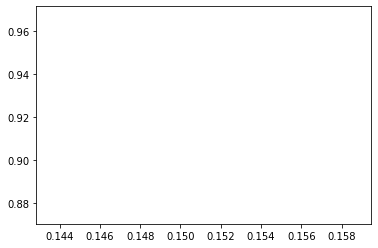

In [70]:
# Logistic Regression ROC Curve
fpr = cm[0,1]/(cm[0,1] + cm[1,1])
tpr = sensitivity
plt.plot(fpr, tpr)
plt.show()

In [56]:
# XGBoost
# https://github.com/dmlc/xgboost/blob/master/python-package/xgboost/sklearn.py


xg_class = xgb.XGBClassifier()
cv = cross_val_score(xg_class, x, y, cv = 5)
print(cv)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (cv.mean() * 100.0, cv.std() * 2))

xg_class = xgb.XGBClassifier(max_depth=5, learning_rate=.3, n_estimators = 20)
xg_class.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_val, y_val)],
             early_stopping_rounds=4)

preds = xg_class.predict(x_test)

accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


[0.86150713 0.89816701 0.85132383 0.89409369 0.88187373]
Accuracy: 87.74% (+/- 0.04%)
[0]	validation_0-error:0.059371	validation_1-error:0.097561
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 4 rounds.
[1]	validation_0-error:0.055879	validation_1-error:0.093496
[2]	validation_0-error:0.055297	validation_1-error:0.097561
[3]	validation_0-error:0.05064	validation_1-error:0.097561
[4]	validation_0-error:0.047148	validation_1-error:0.093496
[5]	validation_0-error:0.045402	validation_1-error:0.097561
Stopping. Best iteration:
[1]	validation_0-error:0.055879	validation_1-error:0.093496

Accuracy: 93.89%



*   Baseline Model Accuracy (w/ Cross Validation): 87.37% +/- 0.06%



In [57]:
# XGBoost Model Evaluation
# Confusion Matrix
cm = skm.confusion_matrix(y_test, preds)
print('Confusion Matrix:', cm)

# Senstivity
# TP/(TP + FN)
sensitivity = cm[0,0]/(cm[0,0] + cm[1,0])
print('Sensitivity: ', sensitivity )

# Specificity
# TN/(TN + FP)
specificity = cm[1,1]/(cm[0,1] + cm[1,1])
print('Specificity: ', specificity)

# Precision
# TP/(TP + FP)
precision = cm[0,0]/(cm[0,1] + cm[0,0])
print('Precision: ', precision)

# Recall
# TP/(TP + FN)
recall = cm[0,0]/(cm[0,0] + cm[1,0])
print('Recall: ', recall)

# F1 Score

Confusion Matrix: [[383   9]
 [ 21  78]]
Sensitivity:  0.948019801980198
Specificity:  0.896551724137931
Precision:  0.9770408163265306
Recall:  0.948019801980198


In [58]:
#xg_class.get_score(importance_type='gain')
print(xg_class.feature_importances_)



[0.01754774 0.02291302 0.07673214 0.0192309  0.01466496 0.03004386
 0.02208773 0.0019864  0.01540312 0.02840586 0.02040794 0.02813603
 0.0251283  0.01708994 0.03148346 0.01691216 0.01043555 0.01746581
 0.01141498 0.5725101  0.        ]


In [ ]:
results = xg_class.evals_result()
results
rmse = np.sqrt(MSE())
plt.figure(figsize = (10,7))
plt.plot(results["validation_0"]["rmse"], label = "Training loss")
plt.plot(results["validation_1"]["rmse"], label = "Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [62]:
# Support Vector Machine
svm = SVC(kernel = 'linear')
cv = cross_val_score(svm, x, y, cv = 5)
print(cv)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (cv.mean() * 100.0, cv.std() * 2))

svm.fit(x_train, y_train)
preds = svm.predict(x_test)
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0.91242363 0.93279022 0.88187373 0.89613035 0.89002037]
Accuracy: 90.26% (+/- 0.04%)
Accuracy: 91.24%



*   Baseline Model Accuracy (w/ Cross Validation): 88.84% +/- 0.05%



In [63]:
# Support Vector Machine Model Evaluation
# Confusion Matrix
cm = skm.confusion_matrix(y_test, preds)
print('Confusion Matrix:', cm)

# Senstivity
# TP/(TP + FN)
sensitivity = cm[0,0]/(cm[0,0] + cm[1,0])
print('Sensitivity: ', sensitivity )

# Specificity
# TN/(TN + FP)
specificity = cm[1,1]/(cm[0,1] + cm[1,1])
print('Specificity: ', specificity)

# Precision
# TP/(TP + FP)
precision = cm[0,0]/(cm[0,1] + cm[0,0])
print('Precision: ', precision)

# Recall
# TP/(TP + FN)
recall = cm[0,0]/(cm[0,0] + cm[1,0])
print('Recall: ', recall)

# F1 Score

Confusion Matrix: [[376  10]
 [ 33  72]]
Sensitivity:  0.9193154034229829
Specificity:  0.8780487804878049
Precision:  0.9740932642487047
Recall:  0.9193154034229829


In [22]:
#Selector object 
sfm = sk.SelectFromModel (xg_class,)

AttributeError: ignored